<a href="https://colab.research.google.com/github/emmazing394/TNM095-AI_for_interactive_media/blob/master/aidraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import os
from tensorflow.keras import layers
import urllib.request
import pandas as pd


Get classes from quick draw dataset. We choose 12 animals from the 345 categories to train our model on.

In [2]:
base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

#classes = ["ant", "bat", "bear", "bee", "bird", "butterfly", "camel", "cat", "cow", "crab",
#          "crocodile", "dog", "dolphin", "dragon", "duck", "elephant", "fish", "flamingo", "frog",
#          "giraffe", "hedgehog", "horse", "kangaroo", "lion", "lobster", "mermaid", "monkey",
#          "mouse", "octopus", "owl", "parrot", "penguin", "pig", "rabbit", "raccoon", "rhinoceros", "scorpion", 
#          "shark", "sheep", "snail", "snake", "snowman", "spider", "squirrel", "swan", "teddy-bear", 
#           "tiger", "whale", "zebra"]

classes = ["ant", "bat", "bee", "bird", "cat", "dog", "dolphin", "fish", 
           "horse", "pig", "rabbit", "swan"]

Create direction objects 

In [3]:
!mkdir -p objects

Download classes to folder objects

In [4]:
def download():

  for c in classes:
    path = base+c+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'objects/'+ c +'.npy')


In [5]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dolphin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/horse.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pig.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swan.npy


Load the .npy files and preprocess the data. 15000 images per class. 80% for training and 20% for testing.

In [105]:
def load_preprocess_data(path, test_ratio=0.2, maxItemsPerClass = 16000):

  #initialize variables
  x = np.empty([0, 784])
  y = np.empty([0])
  
  #load files one by one
  files = [x for x in os.listdir(path)]

  #load to memory
  for i, file in enumerate(files):
    data = np.load(path + "/" + file)
    data = data[0: maxItemsPerClass, :]
    labels = np.full(data.shape[0], i)

    #concatenate to create x and y datasets
    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)

  data = None
  labels = None

  # Randomize the dataset
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]

  #separate into training and testing
  test_size = int(x.shape[0] / 100 * (test_ratio * 100))

  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]

  return x_train, y_train, x_test, y_test



In [106]:
x_train, y_train, x_test, y_test = load_preprocess_data("objects")

In [107]:
print(len(x_train))

153600


Print some random images

Text(0.5, 1.0, 'swan')

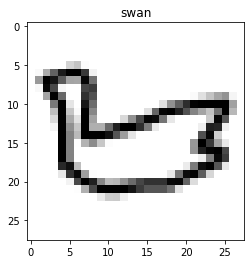

In [117]:
import matplotlib.pyplot as plt
from random import randint

idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28), cmap="gray_r")
plt.title(classes[int(y_train[idx].item())])


In [118]:
# Reshape and normalize, image size is 28x28
#The model will take batches of the shape [N, 28, 28,1]
#Outputs probabilities of the shape [N, 10]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
num_classes = len(class_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [119]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(153600, 28, 28, 1) (153600, 12) (38400, 28, 28, 1) (38400, 12)


In [121]:
# Define model
model = Sequential()
# input image 28x28, 3-channels
model.add(keras.layers.Convolution2D(16, (3, 3), padding="same", input_shape=x_train.shape[1:], activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(32, (3, 3), padding="same", activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(64, (3, 3), padding="same", activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size =(2,2)))
model.add(keras.layers.Dropout(0.2))
# flatten output of convolution from 3D to 1D
model.add(keras.layers.Flatten())
# hidden layer
model.add(keras.layers.Dense(128, activation="relu"))
# output layer
model.add(keras.layers.Dense(12, activation="softmax"))
#compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0

In [122]:
# Train the model
epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=2, epochs=epochs)

Epoch 1/10
4800/4800 - 140s - loss: 0.9573 - accuracy: 0.6932 - val_loss: 0.6904 - val_accuracy: 0.7795
Epoch 2/10
4800/4800 - 137s - loss: 0.6865 - accuracy: 0.7781 - val_loss: 0.6099 - val_accuracy: 0.8052
Epoch 3/10
4800/4800 - 135s - loss: 0.6124 - accuracy: 0.8024 - val_loss: 0.5832 - val_accuracy: 0.8125
Epoch 4/10
4800/4800 - 134s - loss: 0.5692 - accuracy: 0.8144 - val_loss: 0.5633 - val_accuracy: 0.8189
Epoch 5/10
4800/4800 - 133s - loss: 0.5397 - accuracy: 0.8228 - val_loss: 0.5401 - val_accuracy: 0.8246
Epoch 6/10
4800/4800 - 134s - loss: 0.5165 - accuracy: 0.8303 - val_loss: 0.5323 - val_accuracy: 0.8280
Epoch 7/10
4800/4800 - 135s - loss: 0.5022 - accuracy: 0.8351 - val_loss: 0.5207 - val_accuracy: 0.8329
Epoch 8/10
4800/4800 - 137s - loss: 0.4870 - accuracy: 0.8391 - val_loss: 0.5195 - val_accuracy: 0.8324
Epoch 9/10
4800/4800 - 137s - loss: 0.4736 - accuracy: 0.8430 - val_loss: 0.5297 - val_accuracy: 0.8296
Epoch 10/10
4800/4800 - 138s - loss: 0.4644 - accuracy: 0.8461 -

In [123]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1]*100))

Test accuracy: 83.06%


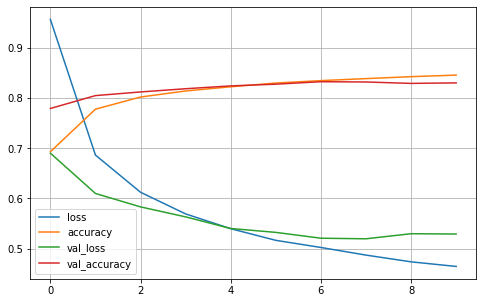

In [124]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

In [125]:
pred = model.predict(x_test)
#results = model.evaluate(x_test, y_test)

#print(f"After 5 epochs, the loss is {results[0]}, and the accuracy is {results[1]}")

Get errors

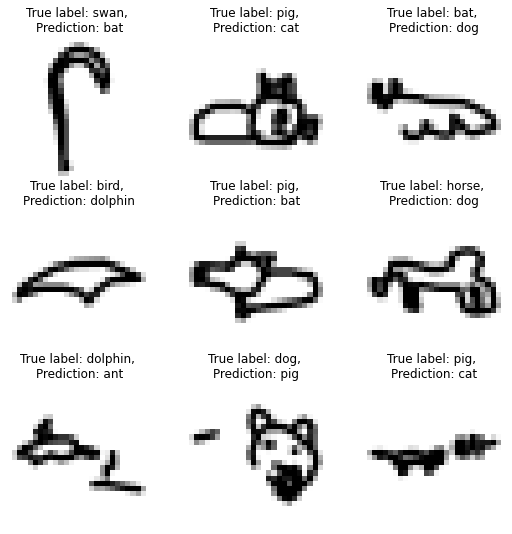

In [127]:
y_pred = np.argmax(pred, axis = 1)
y = np.argmax(y_test, axis = 1)

# Get the indices of the bad labels
bad_pred = np.argwhere((y == y_pred) == False).squeeze()

#Plot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(bad_pred)
    x_show = np.squeeze(x_test[idx])
    ax.imshow(x_show, cmap="gray_r", interpolation="nearest")
    ax.set_title(f"True label: {class_names[y[idx]]}, \nPrediction: {class_names[y_pred[idx]]}")
    ax.axis("off")

Print top 3 predictions for a object

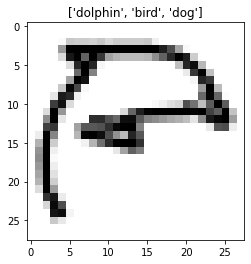

In [128]:
id_x = randint(0, len(x_test))
img = x_test[id_x]
plt.imshow(img.squeeze(), cmap="gray_r")
pred1 = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred1).argsort()[:3]
latex = [class_names[x] for x in ind]
plt.title(latex)
plt.show()

Store the classes

In [129]:
with open('classes.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [130]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 3.0MB/s 


Save and convert model

In [131]:
model.save('keras.h5')

In [132]:
!mkdir -p model
!tensorflowjs_converter --input_format keras keras.h5 model/

2020-11-01 21:52:06.954827: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Download model

In [133]:
!cp classes.txt model/classes.txt

In [134]:
!zip -r newmodel.zip model

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 82%)
  adding: model/classes.txt (deflated 60%)
  adding: model/group1-shard1of1.bin (deflated 7%)


In [135]:
from google.colab import files 
files.download('newmodel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>